In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
main_df = pd.read_csv(r'C:\Users\Abacus_171\Documents\GitHub\CSE498R_SkinCancerDetection\HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


D:\Anaconda\envs\PythonGPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dx', ylabel='count'>

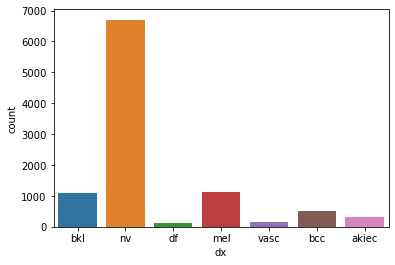

In [3]:
sns.countplot(main_df['dx'])

In [4]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

D:\Anaconda\envs\PythonGPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'scalp'),
  Text(1, 0, 'ear'),
  Text(2, 0, 'face'),
  Text(3, 0, 'back'),
  Text(4, 0, 'trunk'),
  Text(5, 0, 'chest'),
  Text(6, 0, 'upper extremity'),
  Text(7, 0, 'abdomen'),
  Text(8, 0, 'unknown'),
  Text(9, 0, 'lower extremity'),
  Text(10, 0, 'genital'),
  Text(11, 0, 'neck'),
  Text(12, 0, 'hand'),
  Text(13, 0, 'foot'),
  Text(14, 0, 'acral')])

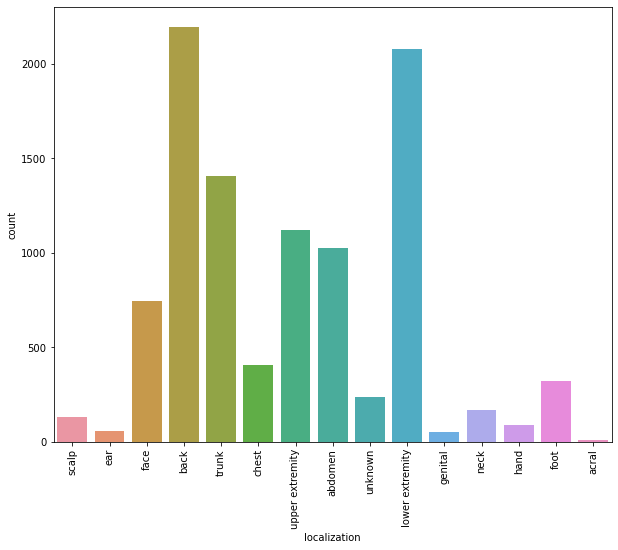

In [5]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

D:\Anaconda\envs\PythonGPU\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dx_type', ylabel='count'>

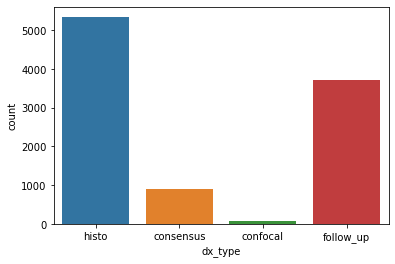

In [6]:
sns.countplot(main_df['dx_type'])

In [7]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [8]:
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [9]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


<AxesSubplot:xlabel='age', ylabel='Density'>

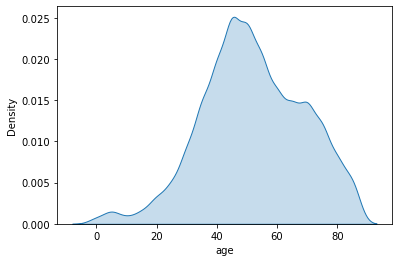

In [10]:
sns.kdeplot(main_df['age'],shade=True)

In [11]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [12]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [13]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

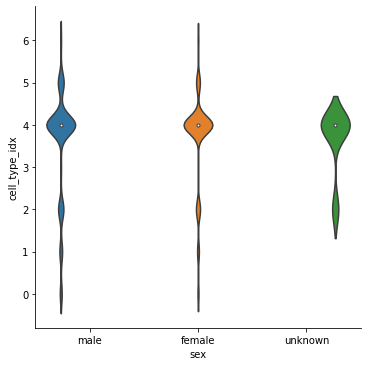

In [14]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

In [15]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [16]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg


In [17]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [18]:
image_example.shape

(450, 600, 3)

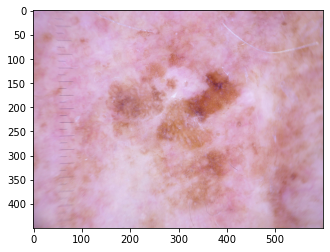

In [19]:
plt.imshow(image_example)

In [20]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [21]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


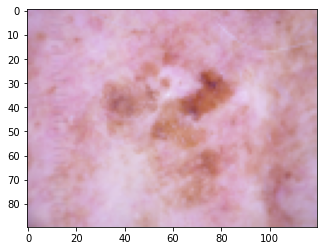

In [22]:
plt.imshow(main_df['image'][0])

In [23]:
main_df['image'][0].shape

(90, 120, 3)

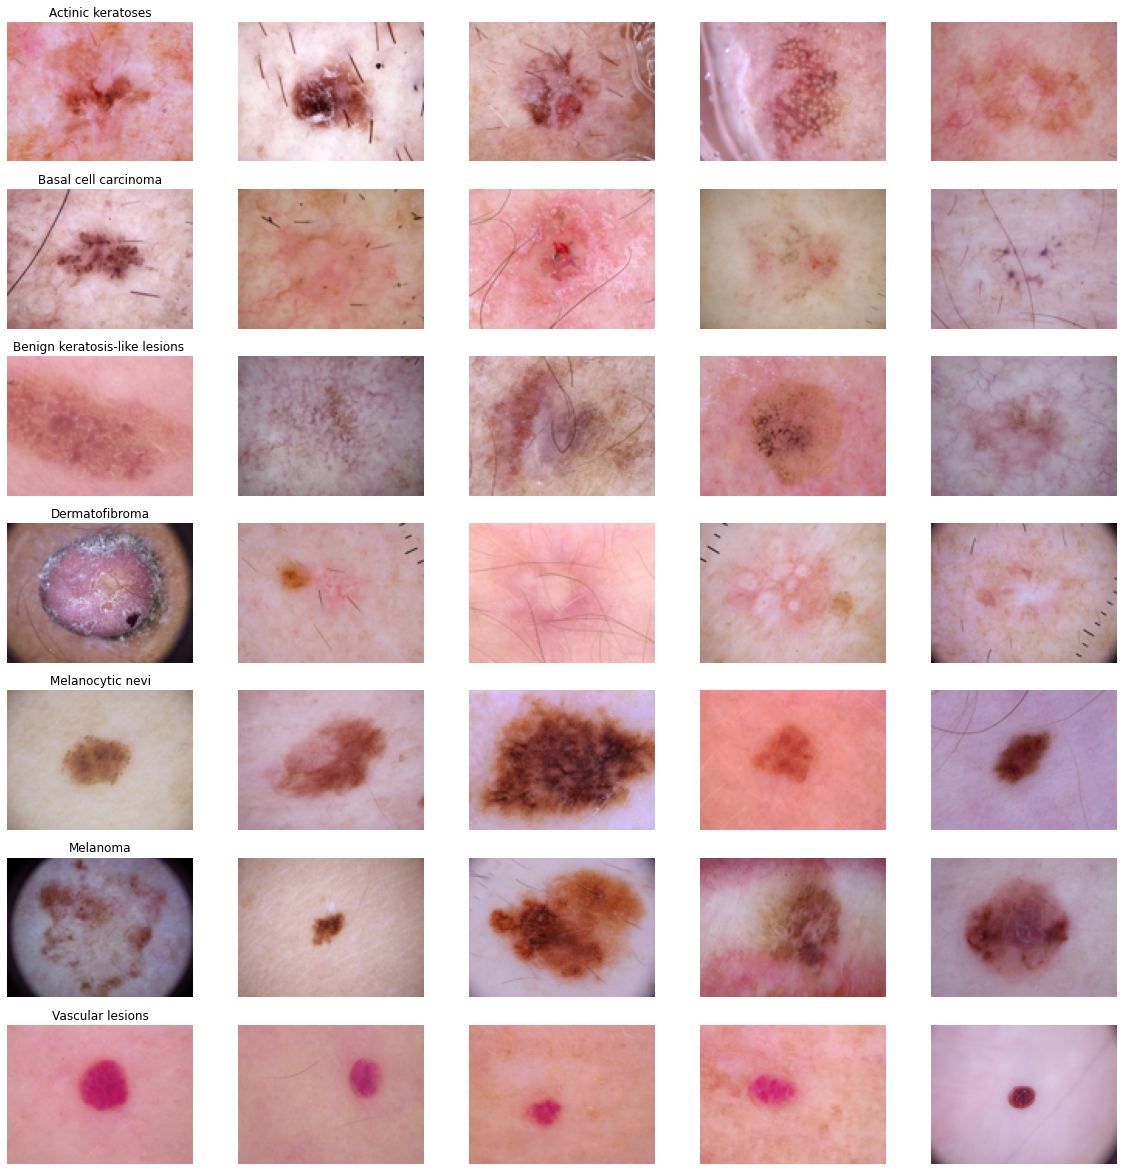

In [24]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

In [25]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [26]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [27]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [28]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train-x_train_mean) / x_train_std
x_test = (x_test-x_test_mean) / x_test_std

In [29]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [30]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [31]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [32]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [33]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

In [34]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


In [35]:
input_shape = (90, 120, 3)
num_classes = 7

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding ='Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 120, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 120, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 30, 64)        0

In [36]:
# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [37]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

In [38]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 30
batch_size = 16
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 526 steps, validate on 1488 samples
Epoch 1/30
526/526 [==============================] - 36s 69ms/step - loss: 1.0480 - accuracy: 0.6556 - val_loss: 0.8382 - val_accuracy: 0.6882
Epoch 2/30
526/526 [==============================] - 29s 56ms/step - loss: 0.9159 - accuracy: 0.6747 - val_loss: 0.8306 - val_accuracy: 0.6989
Epoch 3/30
526/526 [==============================] - 28s 53ms/step - loss: 0.8674 - accuracy: 0.6849 - val_loss: 0.7476 - val_accuracy: 0.7056
Epoch 4/30
526/526 [==============================] - 28s 53ms/step - loss: 0.8422 - accuracy: 0.6954 - val_loss: 0.7543 - val_accuracy: 0.7218
Epoch 5/30
526/526 [==============================] - 30s 57ms/step - loss: 0.8225 - accuracy: 0.7030 - val_loss: 0.7505 - val_accuracy: 0.7352
Epoch 6/30
526/526 [==============================] - 27s 52ms/step - loss: 0.7912 - accuracy: 0.7100 - val_loss: 0.7241 - val_accura

In [39]:
model.save('models/model_SC.h5')

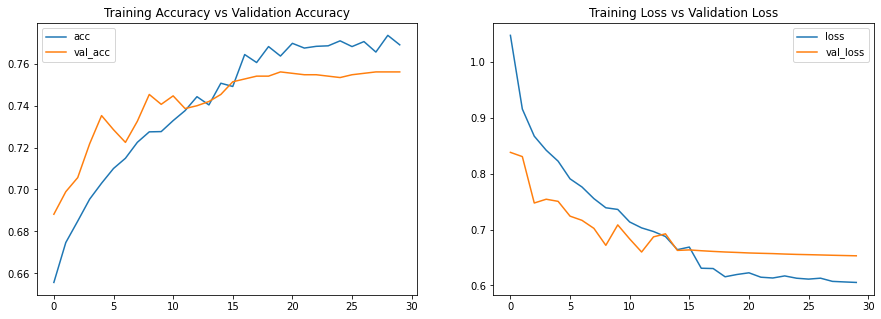

In [40]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [41]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is :  75.6048


ERROR! Session/line number was not unique in database. History logging moved to new session 46
Original Shape of image is :  (500, 600, 3)


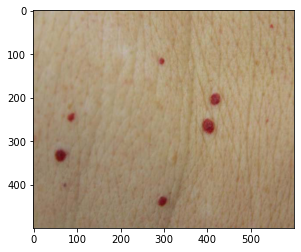

In [43]:
## Let's randomly download a image from internet to test the model.
import urllib

url="https://sunshineforthesoul.co.uk/wp-content/uploads/2019/10/cherry-angioma.jpg"

urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [44]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [45]:
prediction_class = model.predict_classes(test_image)
print(prediction_class)
lesion_classes_dict[prediction_class[0]]

[4]


'akiec'

In [ ]:
batch_size = 64
num_classes = 7
epochs = 20

'''
dropout:None
L2:0.001
'''
#begin layers
def conv_bn_relu(input, block_no):
  ch_in = 16*(2**block_no)
  c1 = Conv2D(ch_in, (3,3),
#               kernel_regularizer=regularizers.l2(0.001),
              kernel_initializer='glorot_uniform',
              padding='same', 
              name='begin_block{}_conv1'.format(block_no),
              use_bias=False)(input)
  c1 = BatchNormalization(name='begin_block{}_norm1'.format(block_no))(c1)
  c1 = ReLU()(c1)
  
  return c1

# Custom ResBlock
def add_resblock(input, dropout_rate = None, layers=2, block_no=1, first_block=False, final_block=False):

#   ch_in = 32 if input.shape[3]==3 else input.shape[3]*2
  ch_in = input.shape[3]*2
#   ch_in = 32 if first_block else input.shape[3]*2
  temp = input
  
  for l in range(layers):
    c1 = Conv2D(int(ch_in*(2**l)),
                (3,3),
                kernel_regularizer=regularizers.l2(0.001),
#                 kernel_initializer='glorot_uniform',
                use_bias=False,
                padding='same', 
                name = 'res_block{}_conv{}'.format(block_no, l+1))(temp)
    if dropout_rate!=None:
      c1 = Dropout(dropout_rate)(c1)
      
    c1 = BatchNormalization(name = 'res_block{}_BN{}'.format(block_no, l+1))(c1)
        
    c1 = ReLU(name = 'res_block{}_relu{}'.format(block_no, l+1))(c1)
    
    temp = c1

    
  concat = Concatenate(axis=-1)([input,temp])


  if not final_block:

    tr_layer = Conv2D(int(ch_in), (1,1),
                      kernel_regularizer=regularizers.l2(0.001),
                      use_bias=False,
                      padding='same', 
                      name = 'res_block{}_transition'.format(block_no))(concat)
    tr_layer = BatchNormalization(name = 'res_block_transition1x1{}_BN'.format(block_no))(tr_layer)
    tr_layer = ReLU(name = 'res_block_transition1x1{}_relu'.format(block_no))(tr_layer)
    
    
    return MaxPooling2D(pool_size=(2, 2))(tr_layer)
  else:
    return concat




# input = Input(shape=(img_height, img_width, channel,))
# input = Input(shape=train_generator.image_shape)
input = Input(shape=(None, None, 3,))

First_Conv2D = conv_bn_relu(input, block_no=1)
# second_Conv2D = conv_bn_relu(First_Conv2D, block_no=2)
# first_maxpool = MaxPooling2D(pool_size=(2, 2), name = 'startmaxpool')(First_Conv2D)

block1 = add_resblock(First_Conv2D, layers=2, block_no=1, first_block=True)

block2 = add_resblock(block1, layers=2, block_no=2)

block3 = add_resblock(block2, layers=2, block_no=3)

block4 = add_resblock(block3, layers=2, block_no=4, final_block=True)

reduce_ch = Conv2D(num_classes, (1,1), name='ch_size_no_classes', use_bias=False)(block4)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)

model = Model(inputs=[input], outputs=[output])
model.summary()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-0c9215c5993e>", line 72, in <module>
    input = Input(shape=(None, None, 3,))
NameError: name 'Input' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "D:\Anaconda\envs\PythonGPU\lib

In [ ]:
#Triangle cyclic learning rate policy

class CyclicLR(Callback):
    

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-861f32fac2a4>", line 3, in <module>
    class CyclicLR(Callback):
NameError: name 'Callback' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "D:\Anaconda\envs\PythonGPU\lib\site-pack

In [ ]:
##1-16 epochs
clr = CyclicLR(base_lr=0.001, max_lr=0.1,
                        step_size=212.)

#SDG 
sgd = SGD(lr=0.1, momentum = 0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer=sgd,
              metrics=['accuracy'])

batch_size = 64

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)

datagen.fit(X_train)

#fit
model.fit_generator(
        datagen.flow(X_train,Y_train,batch_size=batch_size),
        steps_per_epoch = X_train.shape[0] // batch_size,
        epochs=16,
        validation_data=(X_val,Y_val),
        verbose=1, callbacks=[clr],
        )

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-6c4ce1b7c267>", line 2, in <module>
    clr = CyclicLR(base_lr=0.001, max_lr=0.1,
NameError: name 'CyclicLR' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "D:\Anaconda\envs\PythonG

In [ ]:
def plot_(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-b1df2316b5b8>", line 20, in <module>
    plot_(model.history)
  File "<ipython-input-46-b1df2316b5b8>", line 2, in plot_
    acc = history.history['acc']
KeyError: 'acc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context

In [ ]:
print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_acc']),4)*100)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-a0c3c4a3ad1f>", line 1, in <module>
    print("MAXIMUM ACCURACY OF SIMPLE SEQUENTIAL NETWORK is : ", round(max(model.history.history['val_acc']),4)*100)
KeyError: 'val_acc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_cont

In [ ]:
url="https://www.skincorrectives.com/wp-content/uploads/2018/06/vas1.jpg"

urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

ERROR! Session/line number was not unique in database. History logging moved to new session 51


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda\envs\PythonGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-3866eac2cef4>", line 3, in <module>
    urllib.request.urlretrieve(url,'test.jpg')
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 247, in urlretrieve
    with contextlib.closing(urlopen(url, data)) as fp:
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "D:\Anaconda\envs\PythonGPU\lib\urllib\request.py", line 503, i

In [46]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

ERROR! Session/line number was not unique in database. History logging moved to new session 52


In [47]:
prediction_class = model.predict(test_image)
prediction_class = np.argmax(prediction_class,axis=1)

In [48]:
prediction_class

array([4], dtype=int64)

In [49]:
lesion_classes_dict[prediction_class[0]]

'akiec'

In [50]:
prediction_on_test = model.predict(x_test)

In [51]:
prediction_on_test

array([[4.54849669e-09, 1.24177442e-08, 5.44045994e-04, 1.58465286e-06,
        9.99418736e-01, 3.55780503e-05, 3.46514012e-10],
       [3.66654727e-11, 1.42153525e-10, 7.83994547e-05, 1.87190921e-07,
        9.99920607e-01, 8.07179617e-07, 5.89863445e-13],
       [5.27408716e-12, 9.33551327e-12, 2.04069620e-05, 2.01638262e-09,
        9.99968052e-01, 1.15522325e-05, 1.03945888e-12],
       [1.08351391e-02, 1.92264855e-01, 8.88316333e-02, 2.42795050e-02,
        6.60935521e-01, 1.81406979e-02, 4.71269805e-03],
       [2.10814610e-01, 2.15457290e-01, 3.29627454e-01, 3.43894623e-02,
        7.27273673e-02, 1.35797605e-01, 1.18627108e-03],
       [1.74593836e-01, 2.25644961e-01, 1.60402179e-01, 1.02603778e-01,
        2.43251935e-01, 8.85574147e-02, 4.94591566e-03],
       [1.07162271e-03, 1.67502544e-03, 7.66576827e-02, 3.10269650e-04,
        6.90087140e-01, 2.29767174e-01, 4.31098422e-04],
       [2.14958916e-07, 1.05820004e-06, 2.18940899e-03, 7.03624042e-04,
        9.97061789e-01, 4

In [52]:
for i in range(len(x_test)):
  print("Predicted label : ",np.argmax(prediction_on_test[i])," True label : ",Y_TEST[i:i+1].tolist()[0],"\n")

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  2  True label :  0 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  5  True label :  2 

Predicted label :  4  True label :  4 

Predicted label :  5  True label :  2 

Predicted label :  2  True label :  2 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  2 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  1 

Predicted label :  2  True label :  2 

Predicted label :  4  True label :  5 

Predicted label :  4  True label :  4 

Predicted label :  4  True label :  4 

Predicted label :  2  True label :  5 

